# Pairing

In [1]:
import csv
import pandas as pd
from gensim.models import Word2Vec

from src.data_preprocessing.food_normalization import get_food_descriptors
from src.pairing_rules.generate_pairings import generate_pairs
from src.pairing_rules.elimination import eliminate_not_well_together
from src.pairing_rules.congruent_contrasting import congruent_or_contrasting
from src.pairing_rules.similarity import sort_by_aroma_similarity
from src.pairing_rules.visualizations import make_radio_chart

## Preparation

### Loading files from previous stages

In [2]:
wine_vectors = pd.read_csv("../data/wine_aromas_nonaromas.csv", index_col="Unnamed: 0")
wine_vectors["salt"] = 0
wine_vectors.head()

,aroma,weight,sweet,acid,piquant,fat,bitter,salt
"Aglianico, Italian Red, Aglianico del Vulture, Southern Italy, Italy",[ 1.47843817e-02 -2.56521249e+00 -1.55532622e+...,0.440418,0.559137,0.081831,0.074137,0.517114,0.190725,0
"Aglianico, Italian Red, Irpinia, Southern Italy, Italy",[-4.51575547e-01 -2.69118047e+00 -1.72507966e+...,0.487605,0.474853,0.089575,0.076614,0.455151,0.277241,0
"Aglianico, Italian Red, Taurasi, Southern Italy, Italy",[-1.1400039e-01 -2.5102782e+00 -1.4832231e+00 ...,0.463620,0.724887,0.117762,0.097869,0.526619,0.183798,0
"Alsace white blend, White Blend, Alsace, Alsace, France",[-7.26654351e-01 -2.61081553e+00 -1.22374463e+...,0.549080,0.508619,0.128604,0.303001,0.499623,0.582247,0
"Arneis, Italian White, Roero, Piedmont, Italy",[ 1.2258542 -1.9858316 -1.7651796 2.699851...,0.355460,0.373485,0.163732,0.092648,0.433071,0.389474,0


In [3]:
descriptor_frequencies = pd.read_csv("../data/wine_variety_descriptors.csv", index_col="index")

wine_word2vec_model = Word2Vec.load("../data/word2vec.bin")
word_vectors = wine_word2vec_model.wv

food_nonaroma_infos = pd.read_csv(
    "../data/food_nonaroma_info.csv", index_col="Unnamed: 0"
)

### Food descriptors

In [48]:
food_list = ["sauerkraut", "mushroom"]
food_nonaromas, aroma_embedding = get_food_descriptors(food_list, word_vectors, food_nonaroma_infos)

In [49]:
food_nonaromas

{'weight': 0.758819225287306,
 'sweet': 0.42057357852855276,
 'acid': 0.5210777440860835,
 'salt': 0.7743241443939414,
 'piquant': 0.44601388360140093,
 'fat': 0.4849592311265539,
 'bitter': 0.5678644281400493}

## Pairing rules

### Anti-rules
The rules that state which nonaromas don't go well together.

In [50]:
wine_recommendations = wine_vectors.copy()
wine_recommendations = eliminate_not_well_together(wine_recommendations, food_nonaromas)

In [51]:
wine_recommendations.head()

,aroma,weight,sweet,acid,piquant,fat,bitter,salt
"Bordeaux-style Red Blend, Long Island, New York, US",[ 2.5113922e-01 -2.1737587e+00 -1.7401872e+00 ...,0.377431,0.444513,0.710542,0.099916,0.680972,0.191719,0
"Bordeaux-style Red Blend, , Hawkes Bay, New Zealand",[ 0.42870787 -2.2294714 -1.4300964 1.27788 ...,0.584011,0.473775,0.544974,0.098584,0.655516,0.311107,0
"Bordeaux-style Red Blend, , Stellenbosch, South Africa",[ 7.2378337e-01 -2.0855939e+00 -1.6394734e+00 ...,0.558099,0.578521,0.681478,0.069242,0.763244,0.294445,0
"Bordeaux-style Red Blend, Bergerac, Southwest France, France",[ 0.6202891 -2.0802217 -1.9358236 1.082500...,0.420792,0.514417,0.685201,0.081053,0.649495,0.385886,0
"Red Blends, Red Blends, Fronton, Southwest France, France",[-0.12710567 -2.5834289 -1.6242645 2.053866...,0.431736,0.462203,0.594894,0.628058,0.432908,0.292535,0


### Congruent or constrasting

In [52]:
wine_recommendations = congruent_or_contrasting(wine_recommendations, food_nonaromas)

In [53]:
wine_recommendations.value_counts(subset="pairing_type")

pairing_type
               6
contrasting    1
Name: count, dtype: int64

### Sorting by aroma similarity

In [54]:
wine_recommendations = sort_by_aroma_similarity(wine_recommendations, aroma_embedding)
wine_recommendations.sort_values(by="pairing_type", axis=0, ascending=False).head(10)

,aroma,weight,sweet,acid,piquant,fat,bitter,salt,pairing_type,aroma_distance
"Bordeaux-style Red Blend, , Stellenbosch, South Africa","[0.72378337, -2.0855939, -1.6394734, 0.9853870...",0.558099,0.578521,0.681478,0.069242,0.763244,0.294445,0,contrasting,0.656944
"Red Blends, Red Blends, Jumilla, Levante, Spain","[-0.28329897, -3.0330505, -1.3470584, 2.286822...",0.431254,0.428818,0.535099,0.367691,0.444415,0.422006,0,,0.589457
"Red Blends, Red Blends, Montefalco Rosso, Central Italy, Italy","[-0.36585802, -2.8978136, -0.97506666, 2.32817...",0.526771,0.493017,0.644114,0.369825,0.523871,0.434806,0,,0.589920
"Red Blends, Red Blends, Fronton, Southwest France, France","[-0.12710567, -2.5834289, -1.6242645, 2.053866...",0.431736,0.462203,0.594894,0.628058,0.432908,0.292535,0,,0.604778
"Bordeaux-style Red Blend, , Hawkes Bay, New Zealand","[0.42870787, -2.2294714, -1.4300964, 1.27788, ...",0.584011,0.473775,0.544974,0.098584,0.655516,0.311107,0,,0.639503
"Bordeaux-style Red Blend, Long Island, New York, US","[0.25113922, -2.1737587, -1.7401872, 1.1817305...",0.377431,0.444513,0.710542,0.099916,0.680972,0.191719,0,,0.656242
"Bordeaux-style Red Blend, Bergerac, Southwest France, France","[0.6202891, -2.0802217, -1.9358236, 1.0825005,...",0.420792,0.514417,0.685201,0.081053,0.649495,0.385886,0,,0.663813


In [55]:
top_wine = wine_recommendations.sort_values(
    by="pairing_type", axis=0, ascending=False
).iloc[0]
top_wine_dict = top_wine.to_dict()
wine_nonaromas = {key: top_wine_dict[key] for key in food_nonaromas.keys()}

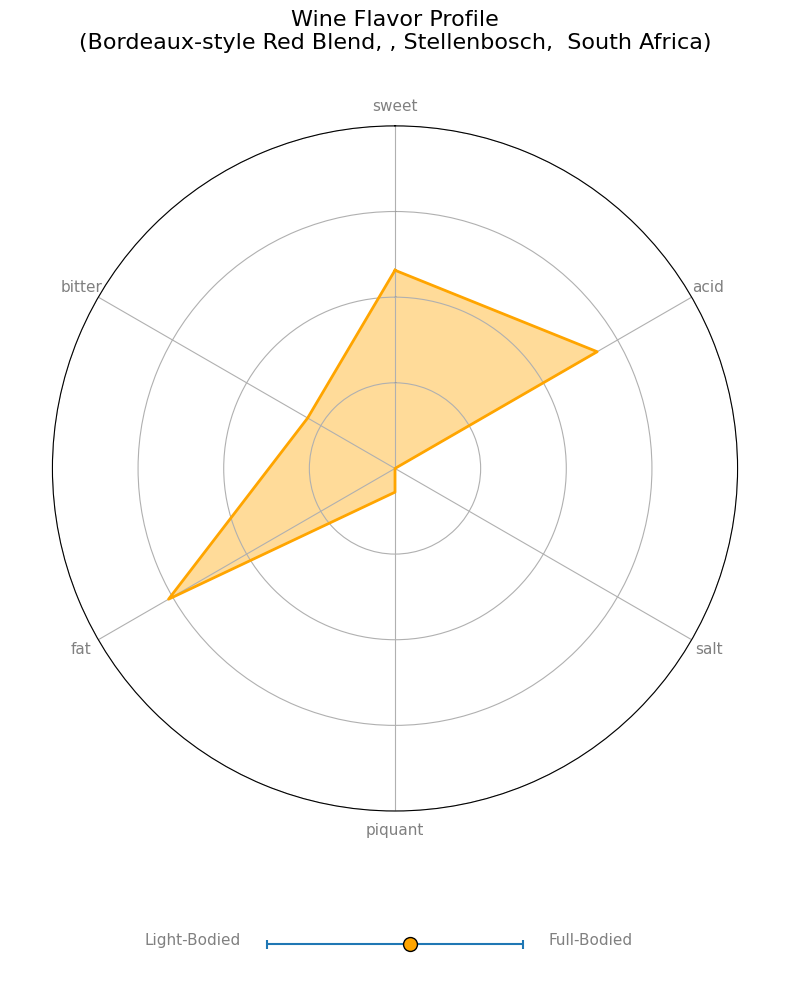

In [56]:
title = "Wine Flavor Profile"
make_radio_chart(wine_nonaromas, title, subtitle=top_wine.name, color="orange")

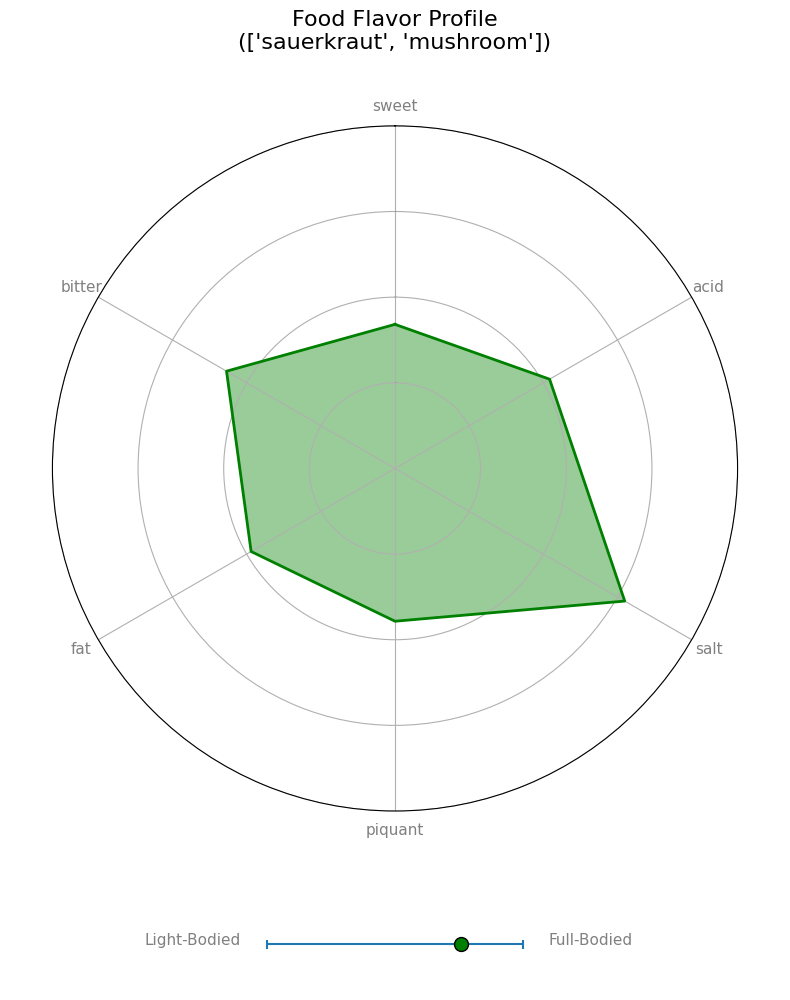

In [57]:
title = "Food Flavor Profile"
make_radio_chart(food_nonaromas, title, subtitle=food_list, color="green")

## List of k-top pairings

In [58]:
with open("../data/intersection_hub_food.csv", "r") as f:
    csv_reader = csv.reader(f)
    food_list_preprocessed = list(csv_reader)[0]
food_df = pd.read_csv("../data/list_of_foods.csv")
food_list = list(food_df["Food"])

In [59]:
food_list = list(set().union(food_list_preprocessed, food_list))

In [60]:
generate_pairs(food_list, wine_vectors, word_vectors, food_nonaroma_infos, K=3)

In [61]:
df = pd.DataFrame.from_dict(top_wine_dict, orient="index")
df.head()